## Itertation 4 BDAS

Eunju Yoon, 200520416, eyoo699@aucklanduni.ac.nz

### 01-BU

#### The objectives of the situation

• Analysis of climate change trends
    Analyze historical climate data to identify trends and patterns in temperature, sea level rise, and other relevant environmental indicators.
    Understanding these trends can help assess the magnitude and direction of climate change.

    
• Prediction of risks by climate change
    Develop predictive models to forecast future climate change risks and their potential impacts on cities in New Zealand.
    This includes predicting the likelihood of extreme events, identifying regions at higher risk, and estimating potential damage.

In [107]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

In [35]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 02-DU

#### Explore data

In [36]:
# Collect initial data
glacier_ice_volumes_data = spark.read.csv('dataset/annual-glacier-ice-volumes-1978-2020.csv', header=True, inferSchema=True)
sea_level_data = spark.read.csv('dataset/annual-mean-sea-level-relative-to-land-19002013.csv', header=True, inferSchema=True)
temperature_anomalies_data = spark.read.csv('dataset/global-and-new-zealand-temperature-anomalies-19092016.csv', header=True, inferSchema=True)
nz_temperature_data = spark.read.csv('dataset/new-zealands-national-temperature-19092016.csv', header=True, inferSchema=True)
sea_surface_temperature_data = spark.read.csv('dataset/oceanic-sea-surface-temperature-19932016.csv', header=True, inferSchema=True)
rainfall_intensity_data = spark.read.csv('dataset/rainfall-intensity-19602016.csv', header=True, inferSchema=True)

In [5]:
# Explore Data
glacier_ice_volumes_data.printSchema()

root
 |-- field_1: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- ice_volume: double (nullable = true)
 |-- unit: string (nullable = true)



In [6]:
# Annual glacier ice volumes
glacier_ice_volumes_data.show()

+-------+----+----------+----+
|field_1|year|ice_volume|unit|
+-------+----+----------+----+
|      1|1978|     53.29|km^3|
|      2|1979|     52.31|km^3|
|      3|1980|     52.31|km^3|
|      4|1981|     52.52|km^3|
|      5|1982|     52.13|km^3|
|      6|1983|     52.93|km^3|
|      7|1984|      53.6|km^3|
|      8|1985|     54.09|km^3|
|      9|1986|     54.12|km^3|
|     10|1987|     54.28|km^3|
|     11|1988|     54.03|km^3|
|     12|1989|     53.88|km^3|
|     13|1990|     52.01|km^3|
|     14|1991|     52.23|km^3|
|     15|1992|     52.96|km^3|
|     16|1993|      53.8|km^3|
|     17|1994|     54.21|km^3|
|     18|1995|     55.22|km^3|
|     19|1996|     55.39|km^3|
|     20|1997|     56.21|km^3|
+-------+----+----------+----+
only showing top 20 rows



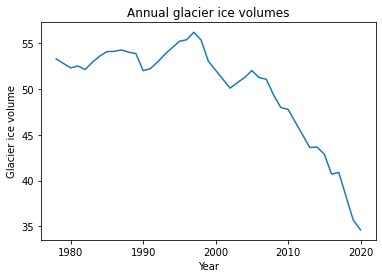

In [10]:
# Visualization for Annual glacier ice volumes
plot_data = glacier_ice_volumes_data.select('year','ice_volume').sample(False, 0.8).toPandas()
plt.plot(plot_data.year, plot_data.ice_volume)
plt.xlabel('Year')
plt.ylabel('Glacier ice volume')
plt.title('Annual glacier ice volumes')
plt.show()

In [11]:
# Annual sea level (relative to land)
sea_level_data.printSchema()

root
 |-- year: integer (nullable = true)
 |-- tide_gauge: string (nullable = true)
 |-- mean_sea_level_metres: double (nullable = true)



In [12]:
sea_level_data.show()

+----+------------+---------------------+
|year|  tide_gauge|mean_sea_level_metres|
+----+------------+---------------------+
|1899|Auckland_MSL|                1.866|
|1900|Auckland_MSL|                1.863|
|1901|Auckland_MSL|                1.823|
|1902|Auckland_MSL|                  0.0|
|1903|Auckland_MSL|                 1.88|
|1904|Auckland_MSL|                1.864|
|1905|Auckland_MSL|                1.843|
|1906|Auckland_MSL|                1.826|
|1907|Auckland_MSL|                1.882|
|1908|Auckland_MSL|                 1.92|
|1909|Auckland_MSL|                1.901|
|1910|Auckland_MSL|                1.928|
|1911|Auckland_MSL|                1.948|
|1912|Auckland_MSL|                1.903|
|1913|Auckland_MSL|                1.873|
|1914|Auckland_MSL|                1.833|
|1915|Auckland_MSL|                1.875|
|1916|Auckland_MSL|                1.928|
|1917|Auckland_MSL|                1.923|
|1918|Auckland_MSL|                1.905|
+----+------------+---------------

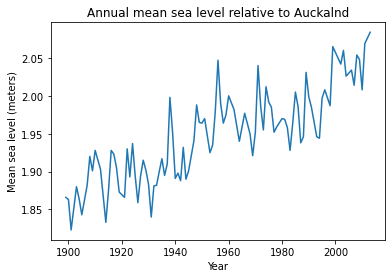

In [13]:
# Visualization for Annual mean sea level relative to Auckaland
plot_data = sea_level_data.filter('tide_gauge == "Auckland_MSL"').filter('mean_sea_level_metres > 0').select('year','mean_sea_level_metres').sample(False, 0.8).toPandas()
plt.plot(plot_data.year, plot_data.mean_sea_level_metres)
plt.xlabel("Year")
plt.ylabel("Mean sea level (meters)")
plt.title("Annual mean sea level relative to Auckalnd")
plt.show()

In [14]:
# Global and New Zealand’s temperature anomalies (1900-2020)
temperature_anomalies_data.printSchema()

root
 |-- Dataset: string (nullable = true)
 |-- Spatial_coverage: string (nullable = true)
 |-- Statistic: string (nullable = true)
 |-- Start_year: integer (nullable = true)
 |-- End_year: integer (nullable = true)
 |-- Temperature_degrees_celcius: double (nullable = true)
 |-- field_7: string (nullable = true)



In [15]:
temperature_anomalies_data.show()

+--------------------+----------------+--------------------+----------+--------+---------------------------+-------+
|             Dataset|Spatial_coverage|           Statistic|Start_year|End_year|Temperature_degrees_celcius|field_7|
+--------------------+----------------+--------------------+----------+--------+---------------------------+-------+
|NZ_7_station_temp...|     New_Zealand|Average_temperatu...|      1909|    1909|                      -0.22|   null|
|NZ_7_station_temp...|     New_Zealand|Average_temperatu...|      1910|    1910|                      -0.15|   null|
|NZ_7_station_temp...|     New_Zealand|Average_temperatu...|      1911|    1911|                      -0.66|   null|
|NZ_7_station_temp...|     New_Zealand|Average_temperatu...|      1912|    1912|                      -1.28|   null|
|NZ_7_station_temp...|     New_Zealand|Average_temperatu...|      1913|    1913|                      -1.04|   null|
|NZ_7_station_temp...|     New_Zealand|Average_temperatu...|    

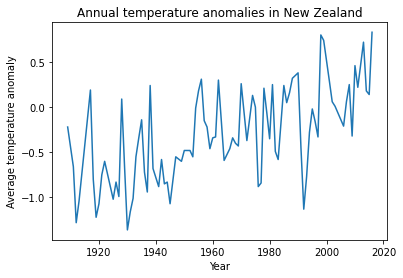

In [16]:
# Visualization for New Zealand’s temperature anomalies (1900-2020)
plot_data = temperature_anomalies_data.filter('Dataset == "NZ_7_station_temperature_time_series"').filter('Statistic == "Average_temperature_anomaly"').select('End_year','Temperature_degrees_celcius').sample(False, 0.8).toPandas()
plt.plot(plot_data.End_year, plot_data.Temperature_degrees_celcius)
plt.xlabel("Year")
plt.ylabel("Average temperature anomaly")
plt.title("Annual temperature anomalies in New Zealand")
plt.show()

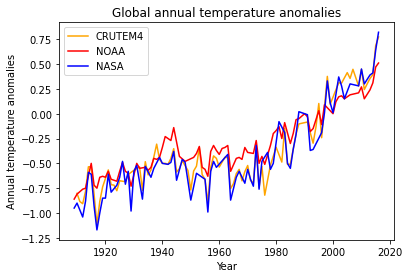

In [17]:
# Visualization for Global temperature anomalies (1900-2020)
plot_data_CRUTEM4 = temperature_anomalies_data.filter('Dataset == "Climatic_Research_Unit_(CRUTEM4)"').filter('Statistic == "Average_temperature_anomaly"').select('End_year','Temperature_degrees_celcius').sample(False, 0.8).toPandas()
plt.plot(plot_data_CRUTEM4.End_year, plot_data_CRUTEM4.Temperature_degrees_celcius, color = 'orange', label = 'CRUTEM4')

plot_data_NOAA = temperature_anomalies_data.filter('Dataset == "National_Oceanic_and_Atmospheric_Administration_(NOAA)"').filter('Statistic == "Average_temperature_anomaly"').select('End_year','Temperature_degrees_celcius').sample(False, 0.8).toPandas()
plt.plot(plot_data_NOAA.End_year, plot_data_NOAA.Temperature_degrees_celcius, color = 'red', label = 'NOAA')

plot_data_NASA = temperature_anomalies_data.filter('Dataset == "National_Aeronautics_and_Space_Administration_(NASA)"').filter('Statistic == "Average_temperature_anomaly"').select('End_year','Temperature_degrees_celcius').sample(False, 0.8).toPandas()
plt.plot(plot_data_NASA.End_year, plot_data_NASA.Temperature_degrees_celcius, color = 'blue', label = 'NASA')

plt.xlabel("Year")
plt.ylabel("Annual temperature anomalies")
plt.title("Global annual temperature anomalies")
plt.legend()
plt.show()

In [18]:
# New Zealand's national temperature (1909–2016)
nz_temperature_data.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Statistic: string (nullable = true)
 |-- Temperature_degrees_celcius: double (nullable = true)



In [19]:
nz_temperature_data.show()

+----+--------------------+---------------------------+
|Year|           Statistic|Temperature_degrees_celcius|
+----+--------------------+---------------------------+
|1909|National_average_...|                      12.39|
|1910|National_average_...|                      12.46|
|1911|National_average_...|                      11.95|
|1912|National_average_...|                      11.33|
|1913|National_average_...|                      11.57|
|1914|National_average_...|                      11.58|
|1915|National_average_...|                      11.94|
|1916|National_average_...|                      12.99|
|1917|National_average_...|                       12.8|
|1918|National_average_...|                      11.81|
|1919|National_average_...|                      11.39|
|1920|National_average_...|                      11.54|
|1921|National_average_...|                      11.86|
|1922|National_average_...|                      12.01|
|1923|National_average_...|                     

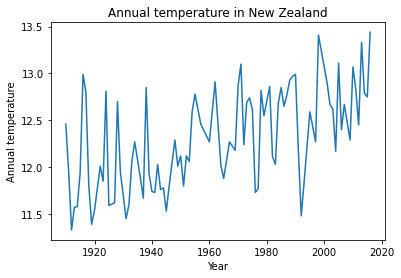

In [20]:
# Visualization for New Zealand's national temperature (1909–2016)
plot_data = nz_temperature_data.filter('Statistic == "National_average_temperature"').select('Year','Temperature_degrees_celcius').sample(False, 0.8).toPandas()

plt.plot(plot_data.Year, plot_data.Temperature_degrees_celcius)
plt.xlabel("Year")
plt.ylabel("Annual temperature")
plt.title("Annual temperature in New Zealand")
plt.show()

In [21]:
# Sea surface mean temperature in New Zealand (1993-2016)
sea_surface_temperature_data.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Area: string (nullable = true)
 |-- Variable: string (nullable = true)
 |-- Statistic: string (nullable = true)
 |-- Value: double (nullable = true)



In [22]:
sea_surface_temperature_data.show()

+----+--------------------+--------------------+---------+-------+
|Year|                Area|            Variable|Statistic|  Value|
+----+--------------------+--------------------+---------+-------+
|1993|New_Zealand_ocean...|Oceanic_sea_surfa...|     Mean|14.3612|
|1994|New_Zealand_ocean...|Oceanic_sea_surfa...|     Mean|14.4678|
|1995|New_Zealand_ocean...|Oceanic_sea_surfa...|     Mean|14.5782|
|1996|New_Zealand_ocean...|Oceanic_sea_surfa...|     Mean| 14.649|
|1997|New_Zealand_ocean...|Oceanic_sea_surfa...|     Mean|14.4728|
|1998|New_Zealand_ocean...|Oceanic_sea_surfa...|     Mean| 14.632|
|1999|New_Zealand_ocean...|Oceanic_sea_surfa...|     Mean|15.0981|
|2000|New_Zealand_ocean...|Oceanic_sea_surfa...|     Mean|14.8112|
|2001|New_Zealand_ocean...|Oceanic_sea_surfa...|     Mean|14.8066|
|2002|New_Zealand_ocean...|Oceanic_sea_surfa...|     Mean|14.8327|
|2003|New_Zealand_ocean...|Oceanic_sea_surfa...|     Mean|14.7494|
|2004|New_Zealand_ocean...|Oceanic_sea_surfa...|     Mean|14.5

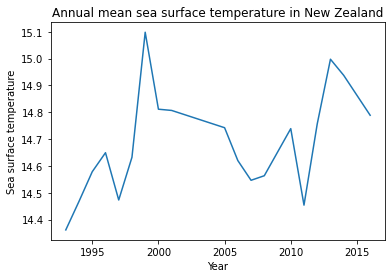

In [23]:
# Visualization for Sea surface mean temperature in New Zealand (1993-2016)
plot_data = sea_surface_temperature_data.filter('Area == "New_Zealand_oceanic_waters"').filter('Variable == "Oceanic_sea_surface_temperature"').filter('Statistic == "Mean"').select('Year','Value').sample(False, 0.8).toPandas()

plt.plot(plot_data.Year, plot_data.Value)
plt.xlabel("Year")
plt.ylabel("Sea surface temperature")
plt.title("Annual mean sea surface temperature in New Zealand")
plt.show()

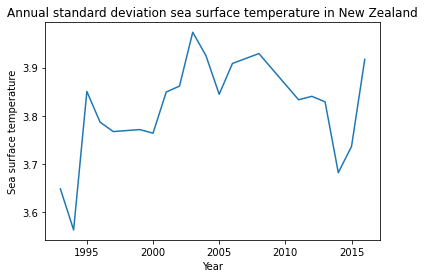

In [24]:
# Visualization for Sea surface stasndard deviation temperature in New Zealand (1993-2016)
plot_data = sea_surface_temperature_data.filter('Area == "New_Zealand_oceanic_waters"').filter('Variable == "Oceanic_sea_surface_temperature"').filter('Statistic == "Standard_Deviation"').select('Year','Value').sample(False, 0.8).toPandas()

plt.plot(plot_data.Year, plot_data.Value)
plt.xlabel("Year")
plt.ylabel("Sea surface temperature")
plt.title("Annual standard deviation sea surface temperature in New Zealand")
plt.show()

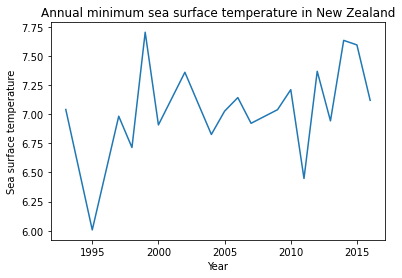

In [25]:
# Visualization for Sea surface minimum temperature in New Zealand (1993-2016)
plot_data = sea_surface_temperature_data.filter('Area == "New_Zealand_oceanic_waters"').filter('Variable == "Oceanic_sea_surface_temperature"').filter('Statistic == "Minimum"').select('Year','Value').sample(False, 0.8).toPandas()

plt.plot(plot_data.Year, plot_data.Value)
plt.xlabel("Year")
plt.ylabel("Sea surface temperature")
plt.title("Annual minimum sea surface temperature in New Zealand")
plt.show()

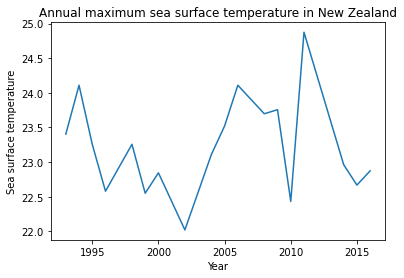

In [26]:
# Visualization for Sea surface maximum temperature in New Zealand (1993-2016)
plot_data = sea_surface_temperature_data.filter('Area == "New_Zealand_oceanic_waters"').filter('Variable == "Oceanic_sea_surface_temperature"').filter('Statistic == "Maximum"').select('Year','Value').sample(False, 0.8).toPandas()

plt.plot(plot_data.Year, plot_data.Value)
plt.xlabel("Year")
plt.ylabel("Sea surface temperature")
plt.title("Annual maximum sea surface temperature in New Zealand")
plt.show()

In [27]:
# Rainfall intensity
rainfall_intensity_data.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- site: string (nullable = true)
 |-- r95ptot: double (nullable = true)
 |-- rx1day: double (nullable = true)



In [28]:
rainfall_intensity_data.show()

+----+--------+-----------+------+
|Year|    site|    r95ptot|rx1day|
+----+--------+-----------+------+
|1960|Auckland|        0.0|   0.0|
|1961|Auckland|        0.0|   0.0|
|1962|Auckland|        0.0|   0.0|
|1963|Auckland|34.24417406|  56.4|
|1964|Auckland|31.89158016|  44.7|
|1965|Auckland|33.39581615|  70.4|
|1966|Auckland|31.24754034|  66.5|
|1967|Auckland|37.46610796| 139.4|
|1968|Auckland|19.86384634|  58.4|
|1969|Auckland| 26.7946185|  58.9|
|1970|Auckland| 32.9884955|  80.3|
|1971|Auckland|27.30793479|  64.7|
|1972|Auckland|27.95676998|  68.5|
|1973|Auckland|16.12903226|  65.1|
|1974|Auckland|23.75152253|  38.0|
|1975|Auckland|21.20684919|  88.8|
|1976|Auckland|35.94574228|  97.0|
|1977|Auckland| 17.5311305|  71.0|
|1978|Auckland|20.92925026|  56.0|
|1979|Auckland|39.40422067|  87.6|
+----+--------+-----------+------+
only showing top 20 rows



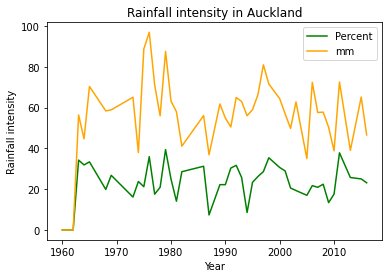

In [29]:
# Visualization for Rainfall intensity in Auckland
plot_data = rainfall_intensity_data.filter('site == "Auckland"').select('Year','r95ptot', 'rx1day').sample(False, 0.8).toPandas()

plt.plot(plot_data.Year, plot_data.r95ptot, color = 'green', label = "Percent")
plt.plot(plot_data.Year, plot_data.rx1day, color = 'orange', label = "mm")
plt.xlabel("Year")
plt.ylabel("Rainfall intensity")
plt.title("Rainfall intensity in Auckland")
plt.legend()
plt.show()

#### Data quality

In [30]:
# Annual glacier ice volumes
glacier_ice_volumes_data.describe().show()

+-------+------------------+------------------+------------------+----+
|summary|           field_1|              year|        ice_volume|unit|
+-------+------------------+------------------+------------------+----+
|  count|                43|                43|                43|  43|
|   mean|              22.0|            1999.0|49.838837209302305|null|
| stddev|12.556538801224908|12.556538801224908| 5.537926468282717|null|
|    min|                 1|              1978|              34.6|km^3|
|    max|                43|              2020|             56.21|km^3|
+-------+------------------+------------------+------------------+----+



In [31]:
glacier_ice_volumes_data.filter('ice_volume == 0').select('*').show()

+-------+----+----------+----+
|field_1|year|ice_volume|unit|
+-------+----+----------+----+
+-------+----+----------+----+



In [32]:
# Annual sea level (relative to land)
sea_level_data.describe().show()

+-------+-----------------+------------+---------------------+
|summary|             year|  tide_gauge|mean_sea_level_metres|
+-------+-----------------+------------+---------------------+
|  count|              575|         575|                  575|
|   mean|           1956.0|        null|   1.0499895652173907|
| stddev|33.22528947394124|        null|   0.6729432854231862|
|    min|             1899|Auckland_MSL|                  0.0|
|    max|             2013|  Wellington|                2.088|
+-------+-----------------+------------+---------------------+



In [33]:
missing_data_in_sea_level_data = sea_level_data.filter('mean_sea_level_metres == 0').select('*')
missing_data_in_sea_level_data.show()
print("The number of missing values: ", missing_data_in_sea_level_data.count())

+----+------------+---------------------+
|year|  tide_gauge|mean_sea_level_metres|
+----+------------+---------------------+
|1902|Auckland_MSL|                  0.0|
|1946|Auckland_MSL|                  0.0|
|1904| Dunedin_MSL|                  0.0|
|1916| Dunedin_MSL|                  0.0|
|1917| Dunedin_MSL|                  0.0|
|1920| Dunedin_MSL|                  0.0|
|1922| Dunedin_MSL|                  0.0|
|1928| Dunedin_MSL|                  0.0|
|1930| Dunedin_MSL|                  0.0|
|1931| Dunedin_MSL|                  0.0|
|1933| Dunedin_MSL|                  0.0|
|1934| Dunedin_MSL|                  0.0|
|1943| Dunedin_MSL|                  0.0|
|1953| Dunedin_MSL|                  0.0|
|1981| Dunedin_MSL|                  0.0|
|1982| Dunedin_MSL|                  0.0|
|1991| Dunedin_MSL|                  0.0|
|1992| Dunedin_MSL|                  0.0|
|1993| Dunedin_MSL|                  0.0|
|1994| Dunedin_MSL|                  0.0|
+----+------------+---------------

In [34]:
# Global and New Zealand temperature anomalies
temperature_anomalies_data.describe().show()

+-------+--------------------+----------------+--------------------+------------------+------------------+---------------------------+-------+
|summary|             Dataset|Spatial_coverage|           Statistic|        Start_year|          End_year|Temperature_degrees_celcius|field_7|
+-------+--------------------+----------------+--------------------+------------------+------------------+---------------------------+-------+
|  count|                 848|             848|                 848|               848|               848|                        848|      0|
|   mean|                null|            null|                null|1961.5188679245282|1963.4811320754718|       -0.35431227712264174|   null|
| stddev|                null|            null|                null|30.648937612208254|30.648937612208318|        0.38472487245810844|   null|
|    min|Climatic_Research...|          Global|Average_temperatu...|              1909|              1909|                      -1.36|   null|

In [35]:
missing_data_in_temperature_anomalies_data = temperature_anomalies_data.filter('Dataset == "NZ_7_station_temperature_time_series"').filter('Statistic == "Average_temperature_anomaly"').filter('Temperature_degrees_celcius == 0').select('*')
missing_data_in_temperature_anomalies_data.show()
print("The number of missing values: ", missing_data_in_temperature_anomalies_data.count())

+--------------------+----------------+--------------------+----------+--------+---------------------------+-------+
|             Dataset|Spatial_coverage|           Statistic|Start_year|End_year|Temperature_degrees_celcius|field_7|
+--------------------+----------------+--------------------+----------+--------+---------------------------+-------+
|NZ_7_station_temp...|     New_Zealand|Average_temperatu...|      1975|    1975|                        0.0|   null|
+--------------------+----------------+--------------------+----------+--------+---------------------------+-------+

The number of missing values:  1


In [36]:
# New Zealand's national temperature
nz_temperature_data.describe().show()

+-------+-----------------+--------------------+---------------------------+
|summary|             Year|           Statistic|Temperature_degrees_celcius|
+-------+-----------------+--------------------+---------------------------+
|  count|              424|                 424|                        424|
|   mean|           1962.5|                null|          5.993183962264144|
| stddev|30.65070506595527|                null|           6.32730833267697|
|    min|             1909|Five-year_running...|                      -1.36|
|    max|             2016|National_average_...|                      13.44|
+-------+-----------------+--------------------+---------------------------+



In [37]:
missing_data_in_nz_temperature_data = nz_temperature_data.filter('Statistic == "National_average_temperature"').filter('Temperature_degrees_celcius == 0').select('*')
missing_data_in_nz_temperature_data.show()

+----+---------+---------------------------+
|Year|Statistic|Temperature_degrees_celcius|
+----+---------+---------------------------+
+----+---------+---------------------------+



In [38]:
# Oceanic sea surface temperature
sea_surface_temperature_data.describe().show()

+-------+-----------------+--------------------+--------------------+------------------+------------------+
|summary|             Year|                Area|            Variable|         Statistic|             Value|
+-------+-----------------+--------------------+--------------------+------------------+------------------+
|  count|              960|                 960|                 960|               960|               960|
|   mean|           2004.5|                null|                null|              null| 525637.5100354946|
| stddev|6.925794677019939|                null|                null|              null|1442978.8746969604|
|    min|             1993|New_Zealand_ocean...|Oceanic_sea_surfa...|           Maximum|          -9.72997|
|    max|             2016|          Tasman_Sea|Oceanic_sea_surfa...|Standard_Deviation|         6451441.0|
+-------+-----------------+--------------------+--------------------+------------------+------------------+



In [39]:
missing_data_in_sea_surface_temperature_data = sea_surface_temperature_data.filter('Area == "New_Zealand_oceanic_waters"').filter('Variable == "Oceanic_sea_surface_temperature"').filter('Statistic == "Mean"').filter('Value == 0').select('*')
missing_data_in_sea_surface_temperature_data.show()

+----+----+--------+---------+-----+
|Year|Area|Variable|Statistic|Value|
+----+----+--------+---------+-----+
+----+----+--------+---------+-----+



In [40]:
# Rainfall Intensity
rainfall_intensity_data.describe().show()

+-------+------------------+---------+------------------+-----------------+
|summary|              Year|     site|           r95ptot|           rx1day|
+-------+------------------+---------+------------------+-----------------+
|  count|              1710|     1710|              1710|             1710|
|   mean|            1988.0|     null|21.915701822702342|67.27411646198829|
| stddev|16.456762861672175|     null|11.099378108277325|54.25926910966994|
|    min|              1960|    0pier|               0.0|              0.0|
|    max|              2016|Whangarei|       54.01682311|            537.5|
+-------+------------------+---------+------------------+-----------------+



In [41]:
missing_data_in_rainfall_intensity_data = rainfall_intensity_data.filter('site == "Auckland"').filter('r95ptot == 0').filter('rx1day == 0').select('*')
missing_data_in_rainfall_intensity_data.show()
print("The number of missing values: ", missing_data_in_rainfall_intensity_data.count())

+----+--------+-------+------+
|Year|    site|r95ptot|rx1day|
+----+--------+-------+------+
|1960|Auckland|    0.0|   0.0|
|1961|Auckland|    0.0|   0.0|
|1962|Auckland|    0.0|   0.0|
+----+--------+-------+------+

The number of missing values:  3


### 03-DP
#### Select data (rows & columns)

In [37]:
glacier_ice = glacier_ice_volumes_data.filter('year >= 1993').filter('year <= 2013').select('year', 'ice_volume')
glacier_ice.describe().show()

+-------+------------------+------------------+
|summary|              year|        ice_volume|
+-------+------------------+------------------+
|  count|                21|                21|
|   mean|            2003.0| 50.94238095238095|
| stddev|6.2048368229954285|3.6954443640270167|
|    min|              1993|             43.57|
|    max|              2013|             56.21|
+-------+------------------+------------------+



In [38]:
auckland_sea_level = sea_level_data.filter('year >= 1993').filter('year <= 2013').filter('tide_gauge == "Auckland_MSL"').select('year', 'mean_sea_level_metres')
auckland_sea_level.describe().show()

+-------+------------------+---------------------+
|summary|              year|mean_sea_level_metres|
+-------+------------------+---------------------+
|  count|                21|                   21|
|   mean|            2003.0|    2.029761904761905|
| stddev|6.2048368229954285|   0.0416940100756749|
|    min|              1993|                1.944|
|    max|              2013|                2.088|
+-------+------------------+---------------------+



In [39]:
avg_temperature_anomalies = temperature_anomalies_data.filter('End_year >= 1993').filter('End_year <= 2013').filter('Dataset == "NZ_7_station_temperature_time_series"').filter('Statistic == "Average_temperature_anomaly"').select('End_year', 'Temperature_degrees_celcius')
avg_temperature_anomalies.describe().show()

+-------+------------------+---------------------------+
|summary|          End_year|Temperature_degrees_celcius|
+-------+------------------+---------------------------+
|  count|                21|                         21|
|   mean|            2003.0|        0.07666666666666669|
| stddev|6.2048368229954285|        0.41519071922832446|
|    min|              1993|                      -0.77|
|    max|              2013|                        0.8|
+-------+------------------+---------------------------+



In [40]:
avg_temperature = nz_temperature_data.filter('Year >= 1993').filter('Year <= 2013').filter('Statistic == "National_average_temperature"').select('Year', 'Temperature_degrees_celcius')
avg_temperature.describe().show()

+-------+------------------+---------------------------+
|summary|              Year|Temperature_degrees_celcius|
+-------+------------------+---------------------------+
|  count|                21|                         21|
|   mean|            2003.0|         12.685714285714285|
| stddev|6.2048368229954285|        0.41596359730836335|
|    min|              1993|                      11.84|
|    max|              2013|                      13.41|
+-------+------------------+---------------------------+



In [41]:
avg_sea_surface_temperature = sea_surface_temperature_data.filter('Year >= 1993').filter('Year <= 2013').filter('Area == "New_Zealand_oceanic_waters"').filter('Statistic == "Mean"').select('Year', 'Value')
avg_sea_surface_temperature.describe().show()

+-------+------------------+------------------+
|summary|              Year|             Value|
+-------+------------------+------------------+
|  count|                21|                21|
|   mean|            2003.0|           14.6637|
| stddev|6.2048368229954285|0.1842655420853289|
|    min|              1993|           14.3612|
|    max|              2013|           15.0981|
+-------+------------------+------------------+



In [42]:
auckland_rainfall = rainfall_intensity_data.filter('Year >= 1993').filter('Year <= 2013').filter('site == "Auckland"').select('Year', 'r95ptot', 'rx1day')
auckland_rainfall.describe().show()

+-------+------------------+------------------+------------------+
|summary|              Year|           r95ptot|            rx1day|
+-------+------------------+------------------+------------------+
|  count|                21|                21|                21|
|   mean|            2003.0|24.144083753952383| 59.37142857142856|
| stddev|6.2048368229954285| 7.120506044203708|13.379280356474437|
|    min|              1993|       8.549147973|              35.0|
|    max|              2013|       37.82564401|              84.8|
+-------+------------------+------------------+------------------+



#### Clean data

In [48]:
auckland_sea_level.filter('mean_sea_level_metres == 0').show()

+----+---------------------+
|year|mean_sea_level_metres|
+----+---------------------+
+----+---------------------+



In [ ]:
# handle missing values using an imputation based on linear regression
prepro_sea_level_data = sea_level_data[(sea_level_data.tide_gauge == 'Auckland_MSL')]
prepro_sea_level_data[(prepro_sea_level_data.mean_sea_level_metres == 0)].count()
prepro_sea_level_data

prepro_sea_level_data = prepro_sea_level_data.replace(0, np.nan)
imputer = IterativeImputer(estimator=LinearRegression())
prepro_sea_level_data[['mean_sea_level_metres', 'year']] = imputer.fit_transform(prepro_sea_level_data[['mean_sea_level_metres', 'year']])
prepro_sea_level_data

#### Construct data

In [54]:
avg_temperature_anomalies = avg_temperature_anomalies.withColumn("year", avg_temperature_anomalies.End_year)

In [55]:
avg_temperature_anomalies.show()

+--------+---------------------------+----+
|End_year|Temperature_degrees_celcius|year|
+--------+---------------------------+----+
|    1993|                      -0.77|1993|
|    1994|                      -0.28|1994|
|    1995|                      -0.02|1995|
|    1996|                      -0.16|1996|
|    1997|                      -0.33|1997|
|    1998|                        0.8|1998|
|    1999|                       0.74|1999|
|    2000|                       0.18|2000|
|    2001|                       0.29|2001|
|    2002|                       0.06|2002|
|    2003|                       0.01|2003|
|    2004|                      -0.44|2004|
|    2005|                        0.5|2005|
|    2006|                      -0.21|2006|
|    2007|                       0.06|2007|
|    2008|                       0.25|2008|
|    2009|                      -0.32|2009|
|    2010|                       0.46|2010|
|    2011|                       0.22|2011|
|    2012|                      

In [56]:
avg_temperature_anomalies = avg_temperature_anomalies.drop('End_year')

In [57]:
avg_temperature_anomalies.show()

+---------------------------+----+
|Temperature_degrees_celcius|year|
+---------------------------+----+
|                      -0.77|1993|
|                      -0.28|1994|
|                      -0.02|1995|
|                      -0.16|1996|
|                      -0.33|1997|
|                        0.8|1998|
|                       0.74|1999|
|                       0.18|2000|
|                       0.29|2001|
|                       0.06|2002|
|                       0.01|2003|
|                      -0.44|2004|
|                        0.5|2005|
|                      -0.21|2006|
|                       0.06|2007|
|                       0.25|2008|
|                      -0.32|2009|
|                       0.46|2010|
|                       0.22|2011|
|                      -0.15|2012|
+---------------------------+----+
only showing top 20 rows



#### Integrate data

In [98]:
climate_data = glacier_ice

In [99]:
climate_data = climate_data.join(auckland_sea_level, on = 'year')

In [100]:
climate_data = climate_data.join(avg_temperature_anomalies, on = 'year')
climate_data = climate_data.withColumnRenamed('Temperature_degrees_celcius', 'temperature_anomalies')

In [101]:
climate_data = climate_data.join(auckland_rainfall, on = 'year')
climate_data = climate_data.withColumnRenamed('r95ptot', 'rainfall_intensity_r95ptot')
climate_data = climate_data.withColumnRenamed('rx1day', 'rainfall_intensity_rx1day')

In [102]:
climate_data = climate_data.join(avg_temperature, on = 'year')
climate_data = climate_data.withColumnRenamed('Temperature_degrees_celcius', 'temperature')

In [103]:
climate_data = climate_data.join(avg_sea_surface_temperature, on = 'year')
climate_data = climate_data.withColumnRenamed('Value', 'sea_surface_temperature')

#### Format data

In [104]:
climate_data = climate_data.withColumn('year', climate_data.year.cast('integer'))
climate_data = climate_data.withColumn('ice_volume', climate_data.ice_volume.cast('double'))
climate_data = climate_data.withColumn('mean_sea_level_metres', climate_data.mean_sea_level_metres.cast('double'))
climate_data = climate_data.withColumn('temperature_anomalies', climate_data.temperature_anomalies.cast('double'))
climate_data = climate_data.withColumn('rainfall_intensity_r95ptot', climate_data.rainfall_intensity_r95ptot.cast('double'))
climate_data = climate_data.withColumn('rainfall_intensity_rx1day', climate_data.rainfall_intensity_rx1day.cast('double'))
climate_data = climate_data.withColumn('temperature', climate_data.temperature.cast('double'))
climate_data = climate_data.withColumn('sea_surface_temperature', climate_data.sea_surface_temperature.cast('double'))

In [105]:
climate_data.printSchema()

root
 |-- year: integer (nullable = true)
 |-- ice_volume: double (nullable = true)
 |-- mean_sea_level_metres: double (nullable = true)
 |-- temperature_anomalies: double (nullable = true)
 |-- rainfall_intensity_r95ptot: double (nullable = true)
 |-- rainfall_intensity_rx1day: double (nullable = true)
 |-- temperature: double (nullable = true)
 |-- sea_surface_temperature: double (nullable = true)



### 04-DT